=============================Código HOG==============================

In [ ]:
import numpy as np
import cv2

def calculate_gradients(image):
    # Calcular los gradientes en las direcciones horizontal y vertical
    kernel_x = np.array([[-1, 0, 1]])
    kernel_y = np.array([[-1], [0], [1]])

    grad_x = cv2.filter2D(image, -1, kernel_x)
    grad_y = cv2.filter2D(image, -1, kernel_y)

    return grad_x, grad_y

def calculate_magnitude_and_angle(grad_x, grad_y):
    # Calcular la magnitud y el ángulo de los gradientes
    magnitude = np.sqrt(grad_x**2 + grad_y**2) #Pitágoras
    angle = np.arctan2(grad_y, grad_x) * 180 / np.pi  # Convertir a grados mediante tangente inversa

    return magnitude, angle

def calculate_hog_descriptor(magnitude, angle, cell_size, block_size, num_bins):
    height, width = magnitude.shape
    cell_height, cell_width = cell_size
    block_height, block_width = block_size

    # Inicializar el descriptor HOG
    hog_descriptor = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell_magnitude = magnitude[i:i+cell_height, j:j+cell_width] #Recorta patch
            cell_angle = angle[i:i+cell_height, j:j+cell_width] #Recorta Patch

            # Calcular el histograma de gradientes para cada patch
            hist = np.zeros(num_bins)
            for m in range(cell_height):
                for n in range(cell_width):
                    bin_idx = int((cell_angle[m-1, n-1] + 180) * num_bins / 360)
                    hist[bin_idx] += cell_magnitude[m-1, n-1]

            hog_descriptor.extend(hist)

    return np.array(hog_descriptor)

def visualize_oriented_gradients(image, magnitude, angle):
    # Crear una imagen en blanco para visualizar los gradientes orientados
    oriented_gradients_image = np.zeros_like(image)

    # Escalar los gradientes para que se puedan visualizar
    max_magnitude = np.max(magnitude)
    scaled_magnitude = (magnitude / max_magnitude) * 255

    # Calcular los componentes x e y de los gradientes orientados
    grad_x = scaled_magnitude * np.cos(np.radians(angle))
    grad_y = scaled_magnitude * np.sin(np.radians(angle))

    # Asignar los gradientes orientados a la imagen
    oriented_gradients_image = cv2.addWeighted(np.uint8(oriented_gradients_image), 1, np.uint8(grad_x), 1, 0)
    oriented_gradients_image = cv2.addWeighted(np.uint8(oriented_gradients_image), 1, np.uint8(grad_y), 1, 0)

    return oriented_gradients_image

In [23]:
# Conectando el drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Implementación HOG librerías**

In [28]:
#Cargando una imagen de prueba.
import cv2 # OpenCV para computer vision
import numpy as np
import matplotlib.pyplot as plt #Para graficar
from skimage.feature import hog
from skimage import exposure
import pandas as pd

#---------------------------------------------------------------------
LBP_Codes = pd.read_excel(r'/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Semana 11y12/LBP_Codes.xlsx')
LBP_Codes = np.array(LBP_Codes)

# Función LBP
def LBP_Brinez(Img_gris,LBP_Codes):

  [Fl, Cl] = Img_gris.shape #Almacena el número de filas y Columnas
  Matriz_LBP = np.zeros((Fl,Cl))
  Pesos = np.array([[1,2,4],[128,0,8],[64,32,16]])

  for j in range(1, Cl-1, 1):            #Columnas, toma la información de todas las columnas evitando información de bordes vacíos en los extremos por eso hay siempre Ncolumnas-2, evitamos el 0 y el
    for i in range(1, Fl-1, 1):          #Filas,toma la información de todas las columnas evitando información de bordes vacíos en los extremos por eso hay siempre Nfilas-2
      Region = Img_gris[i-1:i+2,j-1:j+2] #Garantiza una región móvil de 3x3
      Referencia = Img_gris[i,j]         #Toma el centro de la región 3x3 como referencia
      Region_Bin = Region >= Referencia  #Comprarción Binaria, devuelve 1 cuando es verdadera
      Escalada = Region_Bin*Pesos
      Suma = np.sum(Escalada)
      Codigo = LBP_Codes[Suma,1]         #Toma el valor correspondiente del archivo de excel (0-58)
      Matriz_LBP[i,j] = Codigo

  LBP_Histograna = np.histogram(Matriz_LBP, bins=59, range=(0, 58))
  LBP_Histograna = LBP_Histograna[0]             #Solo tomo los valores de las fercuencias
  LBP_Vector = np.zeros((1,len(LBP_Histograna))) #Vector con ceros
  for i in range(len(LBP_Histograna)):
    LBP_Vector[0,i] = LBP_Histograna[i]          #Se llena el vector con los valores de frecuencias del histograma
  return (Matriz_LBP,LBP_Vector)
#---------------------------------------------------------------------

#Cargando datos
Ruta_dataset = '/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Semana 11y12/IMG'
Filas = 600
Columnas = 600

Longitud = 1176 #Número de características de HOGs
nImagenes = 800 #Cant de imagenes en la carpeta

# Aplicando el proceso a todas las imágenes (Tomando regiones de los rostros)
Matriz_Características = np.zeros((nImagenes, (Longitud + 59 + 1))) #Hogs + LBP + etiqueta

for i in range(1, nImagenes + 1, 1):
  Ruta=Ruta_dataset + '/IM (' + str(i) + ').jpg'
  img=cv2.imread(Ruta)
  I_gris=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  I_gris=cv2.resize(I_gris, (Filas,Columnas), interpolation = cv2.INTER_AREA)

  Recorte = cv2.resize(np.uint8(I_gris), (160,160))

  #Vector Descriptor HOG
  Vector_Hog, HOG_IMG = hog(Recorte, orientations = 6, pixels_per_cell=(20, 20),cells_per_block=(2, 2), visualize=True)

  #Vector Descriptor LBP
  _, Vector_LBP = LBP_Brinez(Recorte, LBP_Codes)
  Vector_LBP_flatten = Vector_LBP.flatten()

  #Unión de descriptores
  vectorDescriptores = np.concatenate((Vector_Hog, Vector_LBP_flatten))
  Matriz_Características[i-1,:-1] = vectorDescriptores

  if i>=1 and i<=200: #Enojado
    Matriz_Características[i-1,-1] = 1
  else:
    if i>=201 and i<=400: #Feliz
      Matriz_Características[i-1,-1]=2
    else:
      if i>=401 and i<=600: #Triste
        Matriz_Características[i-1,-1]=3
      else: #Preocupado
        Matriz_Características[i-1,-1]=4

print(Matriz_Características.shape)

(800, 1236)


In [34]:
#Cargando una imagen de prueba.
import cv2 # OpenCV para computer vision
import numpy as np
import matplotlib.pyplot as plt #Para graficar
from skimage.feature import hog
from skimage import exposure
from skimage.feature import graycoprops
from skimage.feature import graycomatrix as Co_ocurrencia


#Cargando datos rostros Pascual
Ruta_dataset = '/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Semana 11y12/IMG'
Filas = 600
Columnas = 600

Longitud = 1176 #Número de características de HOGs
nImagenes = 1744 #Cant de imagenes en la carpeta

# Aplicando el proceso a todas las imágenes (Tomando regiones de los rostros)
Matriz_Características = np.zeros((nImagenes, Longitud + 7 + 1)) #Hogs + etiqueta

for i in range(1, nImagenes + 1, 1):
  Ruta=Ruta_dataset + '/IM (' + str(i) + ').jpg'
  img=cv2.imread(Ruta)
  I_gris=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  I_gris=cv2.resize(I_gris, (Filas,Columnas), interpolation = cv2.INTER_AREA)

  Recorte = cv2.resize(np.uint8(I_gris), (160,160))

  #Vector Descriptor HOG
  Vector_Hog, HOG_IMG = hog(Recorte, orientations = 6, pixels_per_cell=(20, 20),cells_per_block=(2, 2), visualize=True)

  #Matriz de coocurrencia
  glcm = Co_ocurrencia(I_gris, [1,2,3,4,5,6,7,8,9,10], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
  max_prob = np.max(glcm)

  #vector de coocurrencia
  Vector_GLCM = np.array([
  np.mean(graycoprops(glcm, 'contrast')),
  np.mean(graycoprops(glcm, 'dissimilarity')),
  np.mean(graycoprops(glcm, 'homogeneity')),
  np.mean(graycoprops(glcm, 'ASM')),
  np.mean(graycoprops(glcm, 'energy')),
  np.mean(graycoprops(glcm, 'correlation')),
  np.std(glcm) #rugosity
    ])

  # Combina las características HOG y GLCM en un solo vector
  Vector_Combinado = np.concatenate((Vector_Hog, Vector_GLCM))

  # Añade el vector de características combinado a la matriz de características
  Matriz_Características[i-1,:-1] = Vector_Combinado

  if i>=1 and i<=200: #Enojado
    Matriz_Características[i-1,-1] = 1
  else:
    if i>=201 and i<=400: #Feliz
      Matriz_Características[i-1,-1]=2
    else:
      if i>=401 and i<=600: #Triste
        Matriz_Características[i-1,-1]=3
      else: #Preocupado
        Matriz_Características[i-1,-1]=4

print(Matriz_Características.shape)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
#Dividing dataset into input (X) and output (Y) variables
X = Matriz_Características[:,:-1]
Y = Matriz_Características[:,-1]

#Dividiendo el conjunto de imágenes
from sklearn.model_selection import StratifiedShuffleSplit
Indices = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=18)
for train_index, test_index in Indices.split(X, Y):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

In [ ]:
#Graficando características de un rostro
import matplotlib.pyplot as plt
x = np.zeros((1,Longitud))
x[0,:] = np.arange(0,Longitud,1)
plt.plot(x[0,:],X_train[6,:])
plt.show()

print(X_train[13,:].sum())

Entrenamiento del modelo finalizado
 
Mostrando métricas globales individuales: 
Accuracy KNN 0.25625
Precision KNN 0.2454048204048204
Recall KNN 0.25625
F1_Score KNN 0.23733553651064992
 
Reporte de Clasificación:
               precision    recall  f1-score   support

         1.0       0.28      0.53      0.37        40
         2.0       0.21      0.17      0.19        40
         3.0       0.20      0.12      0.15        40
         4.0       0.29      0.20      0.24        40

    accuracy                           0.26       160
   macro avg       0.25      0.26      0.24       160
weighted avg       0.25      0.26      0.24       160

 


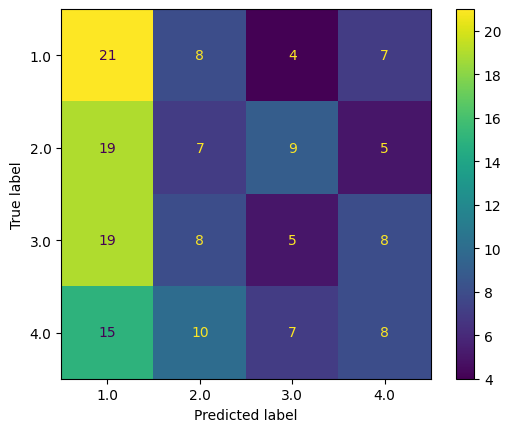

In [31]:
#Evaluando casos mediante todos los clasificadores
from sklearn.neighbors import KNeighborsClassifier
Modelo_0 = KNeighborsClassifier(3)
Modelo_0.fit(X_train, Y_train)
Y_pred_0 =Modelo_0.predict (X_test)
print('Entrenamiento del modelo finalizado')
print(" ")

from sklearn.metrics import confusion_matrix as CM,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score as ACC
from sklearn.metrics import precision_score as PR
from sklearn.metrics import recall_score as RC
from sklearn.metrics import f1_score as F1
from sklearn.metrics import classification_report

print('Mostrando métricas globales individuales: ')
print("Accuracy KNN",ACC(Y_test, Y_pred_0))
print("Precision KNN",PR(Y_test, Y_pred_0, average='macro'))
print("Recall KNN",RC(Y_test, Y_pred_0, average='macro'))
print("F1_Score KNN",F1(Y_test, Y_pred_0, average='macro'))
print(' ')

report = classification_report(Y_test, Y_pred_0)
print("Reporte de Clasificación:\n", report)
print(' ')

Matriz = CM(Y_test, Y_pred_0, labels = Modelo_0.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=Matriz,display_labels  =Modelo_0.classes_)
disp.plot()

Otros descriptores. [Aquí](https://scikit-image.org/docs/stable/api/skimage.feature.html)